# Rate vs Cross section

In general we can write the relation between Rate, $\frac{dR}{d\Omega}$, and the Cross Section, $\frac{d\sigma}{d\Omega}$: 

$$
\frac{dR}{d\Omega} = \epsilon_{spettrometer}(\theta) \frac{n_{gate}}{T} n_c \wp(\theta; \lambda, \lambda') \frac{d\sigma}{d\Omega}
$$
 
where $n_{gate}$ is the number of photons that open the gate and $n_e$ is the density of scattering centers. 

## Geometry parameters

In [325]:
import matplotlib.pyplot as plt
import numpy as np

r_gate = 1.27  #cm
d_gate_source = 18.54 #cm
d_sorg_targ = 4.5 #cm
target_width = 1 #cm 
beta_2 = np.arctan(r_gate / d_gate_source)
r = d_sorg_targ * np.tan(beta_2)
Omega =  (1 - np.cos(beta_2))*2*np.pi #sr   
print (Omega , "str")

0.01468969384187046 str


## Physical parameters

In [326]:
r_e = 2.817e-13  # Classical electron radius in cm
m_e = 511  # Electron rest mass energy in keV
alpha = 1 / 137  # Fine-structure constant (dimensionless)
N_a = 6.022e23 # mol^(-1)

## Calculus of the density of scattering center
We can think that at first approximation, $n_c$ is the number of electrons in the illuminated region of the target, and so it follow the following equation:
$$
n_c = \rho \frac{N_aZ}{\text{MM}}
$$
where: 
- $\rho$ is the density of the scattering target
- $N_a$ is the Avogadro number
- $\text{MM}$ is the molar mass of the scattering target
- $Z$ is the atomic number

In [327]:
#For a Cu target
rho = 8.96 #g/cm^3
Z = 29 #number of electrons
MM = 63.546 #g/mol

n_c = rho *Z* (N_a / MM) 
print(n_c)

2.46239964749945e+24


## Calculus of the number of photons that open the gate
We can think at the number of photons at second that open the gate as: 

$$
\frac{n_{gate}}{T} = \frac{2 S(t) T\text{BR}}{T}\frac{\Delta\Omega}{4\pi}\epsilon_{gate}(511) = 2 S(t) \text{BR}\frac{\Delta\Omega}{4\pi}\epsilon_{gate}(511)
$$

where: 
- $S(t)$ is the activity of the source in Bq
- $\text{BR}$ is the branching ratio of the 511 keV photon
- $T$ is the time of the measurment
- $\frac{\Delta\Omega}{4\pi}$ is the solid angle
- $\epsilon_{gate}(511)$ is the efficiency of the gate detector for the 511 keV photon

In [328]:
S = 188900 #Bq
BR = 0.903
epsilon_gate = 0.147

flux = (2 * S * BR) * (Omega / (4 * np.pi)) * epsilon_gate #s^-1
print(flux, "s^-1")

58.623253720358576 s^-1


# Calculus of the probability factor

We can write (for riflection) $\wp(\theta; \lambda, \lambda')$ as: 
$$
\wp(\theta; \lambda, \lambda') = \lambda'' (1-e^{-\frac{D'}{\lambda''}})
$$

where: 
- $D' = \frac{D}{\cos(\frac{\pi - \theta}{2})}$ and $D$ is the target width
- $\lambda'' = \frac{\lambda\lambda'}{\lambda'+\lambda}$
- $\lambda$ is the mean free path for a 511 keV photon 
- $\lambda'$ is the mean free path for the photon after the scattering


We can also compile the probability factor for trasmission :

$$
\wp(\theta; \lambda, \lambda') = \lambda'' \cdot e^{-D / \lambda'} \cdot \left(1 - e^{-D / \lambda''} \right)

$$
where  $\lambda'' = \frac{\lambda\lambda'}{\lambda'-\lambda}$



### Cross section calculus

In [329]:
def cross_section_thomson():
    """
    Calculate the Thomson cross-section, which represents the scattering 
    of electromagnetic waves by free electrons at low photon energies.

    :return: Thomson cross-section in square meters.
    """
    return (8 / 3) * np.pi * r_e ** 2


def cross_section_photoelectric(energy: float, Z: float) -> float:
    """
    Calculate the photoelectric cross-section for a photon interacting with a material.

    :param photon: Photon object containing energy information (energy in MeV).
    :param Z: Atomic number of the material.
    :return: Photoelectric cross-section in square meters.
    """
    bond_energy = 0.0047  # Example binding energy in keV
    gamma = (energy + m_e - bond_energy) / m_e 
    c = (3 / 2) * (alpha ** 4) * cross_section_thomson()  # Coefficient based on fine-structure constant

    return c * (
        ((Z * m_e / energy) ** 5) *
        (gamma ** 2 - 1) ** (3/2) *
        (
            (4/3) + (gamma * (gamma - 2) / (gamma + 1)) *
            (
                1 - (1 / (2 * gamma * (gamma ** 2 - 1)**(1/2))) *
                np.log((gamma + (gamma ** 2 - 1)**(1/2)) / (gamma - (gamma ** 2 - 1)**(1/2)))
            )
        )
    )


def cross_section_compton(energy: float, Z: float) -> float:
    """
    Calculate the Compton scattering cross-section for a photon interacting with a material.

    :param photon: Photon object containing energy information (energy in MeV).
    :param Z: Atomic number of the material.
    :return: Compton cross-section in square meters.
    """
    epsilon = energy / m_e  # Ratio of photon energy to electron rest mass energy

    # Define calculations for high and low energy regimes
    # These calculations are already vectorized if epsilon is an array
    
    # High energy part
    c_high = 2 * np.pi * r_e ** 2  # Coefficient based on Thomson cross-section
    # Handle potential division by zero if epsilon can be zero or very small.
    # For energy > 100 MeV, epsilon is large.
    term1_high = (1 + epsilon) / epsilon ** 2
    term2_high = (2 * (1 + epsilon) / (1 + 2 * epsilon)) - (np.log(1 + 2 * epsilon) / epsilon)
    term3_high = np.log(1 + 2 * epsilon) / (2 * epsilon)
    term4_high = (1 + 3 * epsilon) / (1 + 2 * epsilon) ** 2
    result_high = c_high * Z * (term1_high * term2_high + term3_high - term4_high)

    # Low energy part
    c_low = cross_section_thomson() 
    poly_term = (
        1 + 2 * epsilon + (6/5) * epsilon ** 2 - (1/2) * epsilon ** 3 +
        (2/7) * epsilon ** 4 - (6/35) * epsilon ** 5 + (8/105) * epsilon ** 6 + (4/105) * epsilon ** 7
    )
    result_low = c_low * Z * (1 / (1 + 2 * epsilon) ** 2) * poly_term
    
    # Use np.where to choose between high and low energy calculations
    return np.where(energy > 100, result_high, result_low)

### $\lambda$ calculus
$$
\lambda = \frac{1}{n_c\sigma_{tot}}
$$

In [330]:
def attenuation_factor(total_cross_section: float, density_of_scattering_centers: float) -> float:
    """
    Calculate the attenuation factor for a photon traveling through a material.

    :param total_cross_section: Total cross-section for the interaction (in cm²).
    :param scattering_target: Material properties (e.g., density, molar mass).
    :return: Attenuation factor (inverse mean free path).
    """
    return total_cross_section * density_of_scattering_centers # cm^-1

def attenuation_length(attenuation_factor: float) -> float:
    """
    Calculate the attenuation length for a photon traveling through a material.

    :param attenuation_factor: Attenuation factor (inverse mean free path).
    :return: Attenuation length in cm.
    """
    return 1 / attenuation_factor  # cm


/tmp/ipykernel_1127/4185494503.py:20: RuntimeWarning: divide by zero encountered in divide
  lam_dubprime = (lam * lam_prime) / (lam_prime - lam)
/tmp/ipykernel_1127/4185494503.py:22: RuntimeWarning: invalid value encountered in multiply
  return lam_dubprime * np.exp(-D/lam_prime)*(1 - np.exp(-D / lam_dubprime))


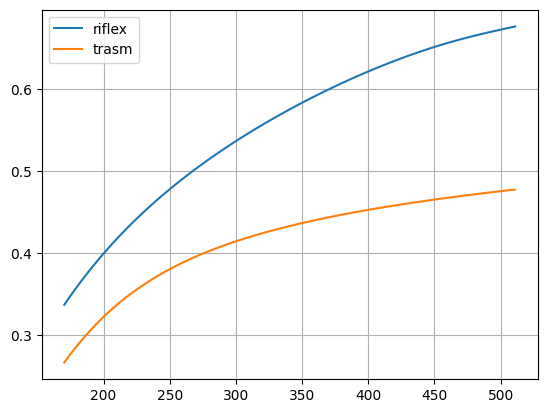

In [331]:
def compton_scattering(theta):
    return 511 / (2 - np.cos(theta))

def prob_riflex(theta):
    D_prime = target_width / np.cos((np.pi - theta)/2)
    E = 511
    E_prime = compton_scattering(theta)
    lam = attenuation_length(attenuation_factor(cross_section_compton(E, Z) + cross_section_photoelectric(E, Z), rho * (N_a / MM)))
    lam_prime = attenuation_length(attenuation_factor(cross_section_compton(E_prime, Z) + cross_section_photoelectric(E_prime, Z), rho  *(N_a / MM)))
    lam_dubprime = (lam * lam_prime) / (lam_prime + lam)
    
    return lam_dubprime * (1 - np.exp(-D_prime / lam_dubprime))

def prob_trasm(theta):
    D = target_width
    E = 511
    E_prime = compton_scattering(theta)
    lam = attenuation_length(attenuation_factor(cross_section_compton(E, Z) + cross_section_photoelectric(E, Z), rho * (N_a / MM)))
    lam_prime = attenuation_length(attenuation_factor(cross_section_compton(E_prime, Z) + cross_section_photoelectric(E_prime, Z), rho  *(N_a / MM)))
    lam_dubprime = (lam * lam_prime) / (lam_prime - lam)
    
    return lam_dubprime * np.exp(-D/lam_prime)*(1 - np.exp(-D / lam_dubprime))
 
thetas = np.linspace(0, np.pi, 100)
plt.plot(compton_scattering(thetas), prob_riflex(thetas), label ="riflex")
plt.plot(compton_scattering(thetas), prob_trasm(thetas), label = "trasm")
plt.legend()
plt.grid()
plt.show()

## Calculus of the efficiency

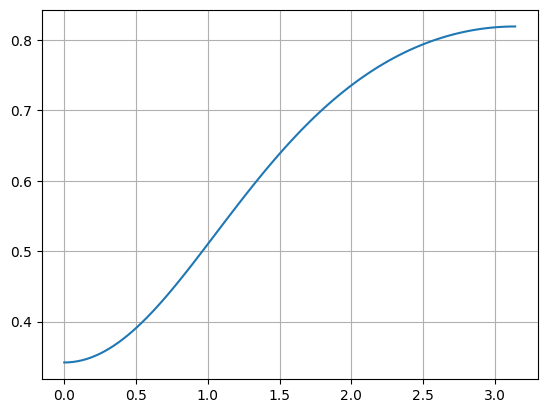

In [332]:
def epsilon_spettrometer(theta): 
    A = 1.55710
    B = -0.09831
    C = 3.53226
    D = 0.10209
   
    E  = compton_scattering(theta) * 1e-3 #da MeV a keV

    return A * pow(E, -B) * np.exp(-C * E) + D

plt.plot(thetas, epsilon_spettrometer(thetas))
plt.grid()
plt.show()

## Total correction 

/tmp/ipykernel_1127/4185494503.py:20: RuntimeWarning: divide by zero encountered in divide
  lam_dubprime = (lam * lam_prime) / (lam_prime - lam)
/tmp/ipykernel_1127/4185494503.py:22: RuntimeWarning: invalid value encountered in multiply
  return lam_dubprime * np.exp(-D/lam_prime)*(1 - np.exp(-D / lam_dubprime))


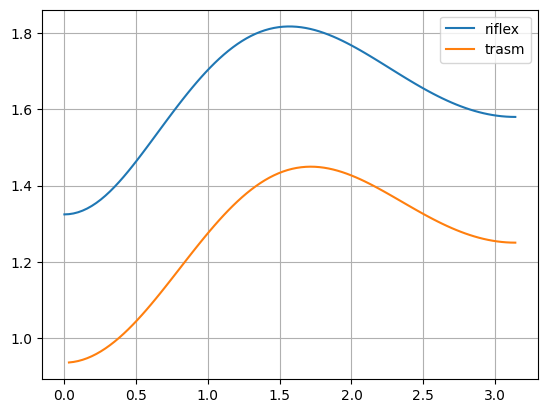

In [333]:
def const_riflex (theta):
    return (r_e ** 2 / 2) * n_c * flux * prob_riflex(theta) * epsilon_spettrometer(theta)

def const_trasm (theta):
    return (r_e ** 2 / 2) * n_c * flux * prob_trasm(theta) * epsilon_spettrometer(theta)

plt.plot(thetas, const_riflex(thetas), label = "riflex")
plt.plot(thetas, const_trasm(thetas),label = "trasm")
plt.legend()
plt.grid()
plt.show()

## Klein-Nishina
$$
\frac{d\sigma}{d\Omega} = \bigg(\frac{\omega'}{\omega}\bigg)^2\bigg[\frac{\omega'}{\omega} + \frac{\omega}{\omega'} - \sin^2(\theta)\bigg]
$$


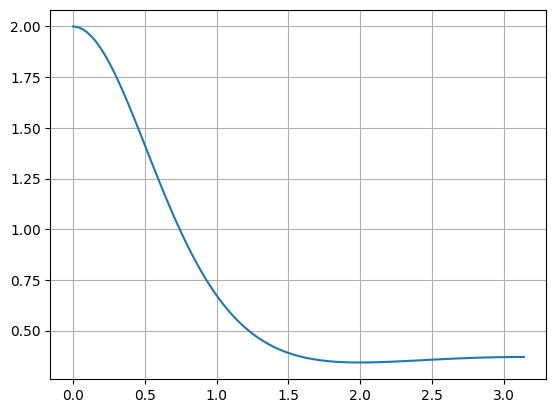

In [334]:
#andamento funzionale della KN
def klein_nishina(theta):
    E = compton_scattering(theta)
    r = E / 511
    return r ** 2 * (r + 1/r - np.sin(theta) ** 2)

plt.plot(thetas, klein_nishina(thetas))
plt.grid()
plt.show()

In [335]:
#VALORI DI CORREZIONE DELL'ANGOLO SOLIDO DELLO SPETTROMETRO


# Dati tabella: angoli in gradi e valori corrispondenti
angles_deg_riflex = np.array([
    140, 135, 130, 125, 120, 115, 110, 105, 100, 95,
    90, 85, 80, 75, 70, 65, 60, 55, 50, 45,
    40, 35, 30, 25, 20
])

#N.B. PER IL 35 HO USATO IL VALORE IN TRASMISSIONE A 45 CM 
values = np.array([
    0.03244310169, 0.03244310169, 0.03249877382, 0.03249877382, 0.03249877382,
    0.03244310169, 0.03244310169, 0.03249877382, 0.03249877382, 0.03249877382,
    0.03244310169, 0.03244310169, 0.03244310169, 0.03244310169, 0.03244310169,
    0.03255449356, 0.03255449356, 0.03261026089, 0.03261026089, 0.0327778485,
    0.03288981157, 0.03300196504, 0.03322684314, 0.03345248278, 0.03384918453,
    0.03436265618, 0.03522700787, 0.03669138374, 0.03964779781, 0.04777407735
]) 

angle_trasm_25 = 0.02686251355
angle_trasm_45 = 0.009017319376

def angle_spectrometer(theta):
    # Converti radianti in gradi
    angle_deg = np.degrees(theta)
    
    # Trova indice del valore con angolo più vicino
    idx = (np.abs(angles_deg_riflex - angle_deg)).argmin()
    
    # Restituisci il valore corrispondente
    return 0.027       #METTENDO QUI IL VALORE DI 0.027 è UN VALOR MEDIO USANDO UNA PROFONDITà DI FUGA DI 2.54 CM


In [336]:
#lettura dati

def leggi_dati(file_path):
    # Inizializza liste per ogni colonna
    angle, rate, err_rate = [], [], []
    count, err_count = [], []
    channel, err_channel = [], []
    sigma, err_sigma = [], []

    with open(file_path, 'r') as file:
        lines = file.readlines()

        # Salta l'intestazione
        for line in lines[1:]:
            valori = line.strip().split()
            if len(valori) != 9:
                continue  # Salta righe non valide

            angle.append(float(valori[0]))
            rate.append(float(valori[1]))
            err_rate.append(float(valori[2]))
            count.append(float(valori[3]))
            err_count.append(float(valori[4]))
            channel.append(float(valori[5]))
            err_channel.append(float(valori[6]))
            sigma.append(float(valori[7]))
            err_sigma.append(float(valori[8]))

    return angle, rate, err_rate, count, err_count, channel, err_channel, sigma, err_sigma

file_path = "../../Codes/data_analysis/parameters_pol4_riflection.txt"

angle, rate, err_rate, count, err_count, channel, err_channel, sigma, err_sigma = leggi_dati(file_path)

file_path = "../../Codes/data_analysis/parameters_pol4_trasmission.txt"

angle_trasm, rate_trasm, err_rate_trasm, count_trasm, err_count_trasm, channel_trasm, err_channel_trasm, sigma_trasm, err_sigma_trasm = leggi_dati(file_path)

In [337]:
data = np.load('../../Measurments/errori_arrays_riflex.npz')
y_err = data['y_err']
x_err = data['x_err']

print(y_err, x_err)

data = np.load('../../Measurments/errori_arrays_trasm.npz')
y_err_trasm = data['y_err']
x_err_trasm = data['x_err']

print(y_err_trasm, x_err_trasm)

[0.17222895 0.48804469 0.40595746 0.27685635 0.1581006  0.29342592
 0.14518601 0.16398483] [0.06126201 0.06186401 0.06606664 0.07317939 0.08345257 0.09726168
 0.11546302 0.1393776 ]
[0.77354049 0.22519077 0.47691257] [0.06270013 0.0612508  0.06191892]


## Complete Klein-Nishina (with correction)

/tmp/ipykernel_1127/4185494503.py:20: RuntimeWarning: divide by zero encountered in divide
  lam_dubprime = (lam * lam_prime) / (lam_prime - lam)
/tmp/ipykernel_1127/4185494503.py:22: RuntimeWarning: invalid value encountered in multiply
  return lam_dubprime * np.exp(-D/lam_prime)*(1 - np.exp(-D / lam_dubprime))


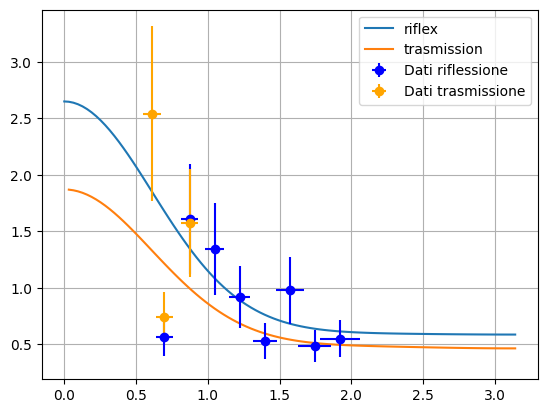

In [338]:
def rate_function_riflex(theta):
    return const_riflex(theta) * klein_nishina(theta)

def rate_function_trasm(theta):
    return const_trasm(theta) * klein_nishina(theta)


angles = np.radians(angle)
angles_trasm = np.radians(angle_trasm)


# Calcola i valori corrispondenti di angle_spectrometer per ogni angolo
spectrometer_values = np.array([angle_spectrometer(theta) for theta in angles])
spectrometer_values_trasm = np.array([angle_trasm_45, angle_trasm_25, angle_trasm_45]) # rispettivamente 35 ,40 ,50 deg

# Dividi ogni rate per il corrispondente valore di angle_spectrometer
corrected_rates = rate / spectrometer_values
corrected_rates_trasm = rate_trasm / spectrometer_values_trasm

plt.plot(thetas, rate_function_riflex(thetas),label="riflex")
plt.plot(thetas, rate_function_trasm(thetas), label ="trasmission")

plt.errorbar(angles, corrected_rates, yerr=y_err, xerr=x_err, fmt='o', color='blue', label='Dati riflessione')
plt.errorbar(angles_trasm, corrected_rates_trasm, yerr=y_err_trasm, xerr=x_err_trasm, fmt='o', color='orange', label='Dati trasmissione')
plt.grid()
plt.legend()
plt.show()

## Fit

TRASMISSIONE
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  33e-27   │   7e-27   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
Chi2: 7.29, NDF: 2.0


/tmp/ipykernel_1127/4185494503.py:20: RuntimeWarning: divide by zero encountered in divide
  lam_dubprime = (lam * lam_prime) / (lam_prime - lam)
/tmp/ipykernel_1127/4185494503.py:22: RuntimeWarning: invalid value encountered in multiply
  return lam_dubprime * np.exp(-D/lam_prime)*(1 - np.exp(-D / lam_dubprime))


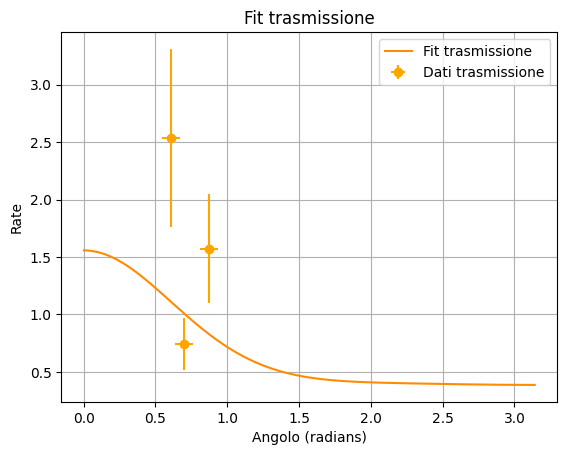


--- RISULTATI TRASMISSIONE ---
Fitted value of a: 3.305101840363899e-26
Error on a: 6.587967017777442e-27
r_e (true): 2.817e-13
Valore di r_e: 2.5710316374420207e-13
Incertezza su r_e: 2.5623827112185848e-14


In [339]:
from iminuit import Minuit
from iminuit.cost import LeastSquares

# === Funzione da fittare ===
def fit_function_trasm(theta, a):
    return klein_nishina(theta) * flux * n_c * prob_trasm(theta) * epsilon_spettrometer(theta) * a

# === Fit ===
least_squares_trasm = LeastSquares(angles_trasm, corrected_rates_trasm, y_err_trasm, fit_function_trasm)
m_trasm = Minuit(least_squares_trasm, a=1.0)
m_trasm.migrad()

# === Risultati ===
print("TRASMISSIONE")
print(m_trasm.params)
print(f"Chi2: {m_trasm.fval:.2f}, NDF: {m_trasm.ndof}")

# === Plot ===
plt.errorbar(angles_trasm, corrected_rates_trasm, yerr=y_err_trasm, xerr=x_err_trasm, fmt='o', color='orange', label='Dati trasmissione')
fit_theta_fine = np.linspace(0, np.pi, 2000)
a_fit_trasm = m_trasm.values["a"]
plt.plot(fit_theta_fine, fit_function_trasm(fit_theta_fine, a_fit_trasm), label="Fit trasmissione", color='darkorange')

plt.xlabel("Angolo (radians)")
plt.ylabel("Rate")
plt.legend()
plt.grid()
plt.title("Fit trasmissione")
plt.show()

# === Calcolo r_e ===
a_err_trasm = m_trasm.errors["a"]
f_trasm = np.sqrt(2 * a_fit_trasm)
f_err_trasm = (1 / np.sqrt(2 * a_fit_trasm)) * a_err_trasm

print("\n--- RISULTATI TRASMISSIONE ---")
print(f"Fitted value of a: {a_fit_trasm}")
print(f"Error on a: {a_err_trasm}")
print(f"r_e (true): {r_e}")
print(f"Valore di r_e: {f_trasm}")
print(f"Incertezza su r_e: {f_err_trasm}")



RIFLESSIONE
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │ 24.3e-27  │  2.9e-27  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
Chi2: 19.57, NDF: 7.0


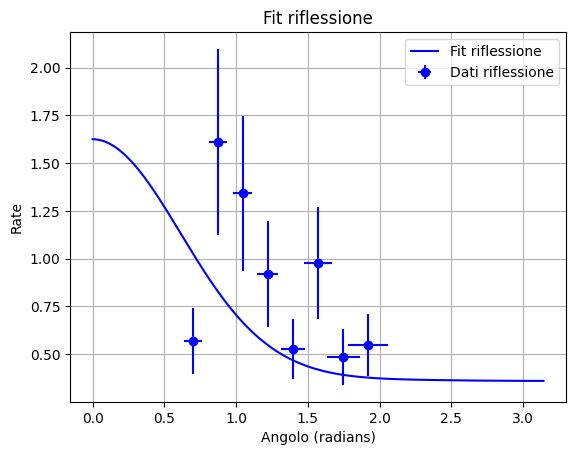


--- RISULTATI RIFLESSIONE ---
Fitted value of a: 2.4348984840977798e-26
Error on a: 2.9419025149668044e-27
r_e (true): 2.817e-13
Valore di r_e: 2.2067616473456212e-13
Incertezza su r_e: 1.3331310694589239e-14


In [340]:

# === Funzione da fittare ===
def fit_function_riflex(theta, a):
    return klein_nishina(theta) * flux * n_c * prob_riflex(theta) * epsilon_spettrometer(theta) * a

# === Fit ===
least_squares_riflex = LeastSquares(angles, corrected_rates, y_err, fit_function_riflex)
m_riflex = Minuit(least_squares_riflex, a=1.0)
m_riflex.migrad()

# === Risultati ===
print("RIFLESSIONE")
print(m_riflex.params)
print(f"Chi2: {m_riflex.fval:.2f}, NDF: {m_riflex.ndof}")

# === Plot ===
plt.errorbar(angles, corrected_rates, yerr=y_err, xerr=x_err, fmt='o', color='blue', label='Dati riflessione')
fit_theta_fine = np.linspace(0, np.pi, 2000)
a_fit_riflex = m_riflex.values["a"]
plt.plot(fit_theta_fine, fit_function_riflex(fit_theta_fine, a_fit_riflex), label="Fit riflessione", color='blue')

plt.xlabel("Angolo (radians)")
plt.ylabel("Rate")
plt.legend()
plt.grid()
plt.title("Fit riflessione")
plt.show()

# === Calcolo r_e ===
a_err_riflex = m_riflex.errors["a"]
f_riflex = np.sqrt(2 * a_fit_riflex)
f_err_riflex = (1 / np.sqrt(2 * a_fit_riflex)) * a_err_riflex

print("\n--- RISULTATI RIFLESSIONE ---")
print(f"Fitted value of a: {a_fit_riflex}")
print(f"Error on a: {a_err_riflex}")
print(f"r_e (true): {r_e}")
print(f"Valore di r_e: {f_riflex}")
print(f"Incertezza su r_e: {f_err_riflex}")
